# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [4]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

JSONDecodeError: Unterminated string starting at: line 1 column 313069298 (char 313069297)

In [ ]:
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,RCE,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,NaN,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,NaN,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,NaN,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,NaN,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN


<AxesSubplot: ylabel='Frequency'>

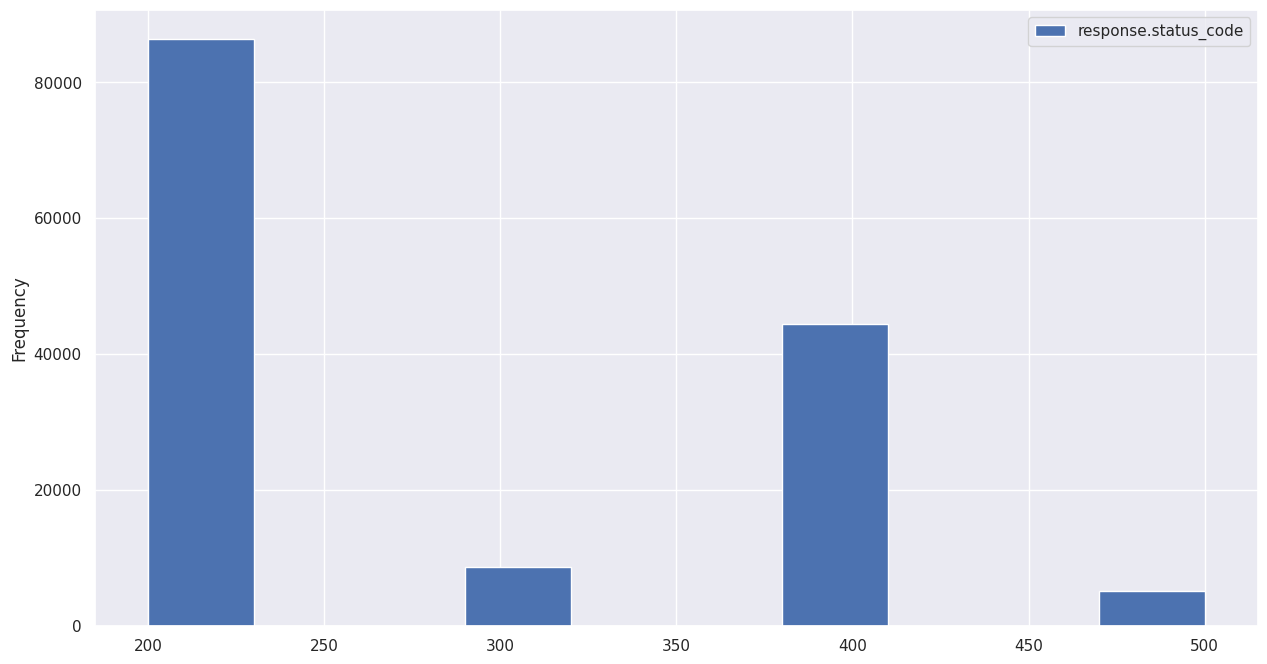

In [ ]:
df.plot.hist(x='response.status')


<AxesSubplot: ylabel='Frequency'>

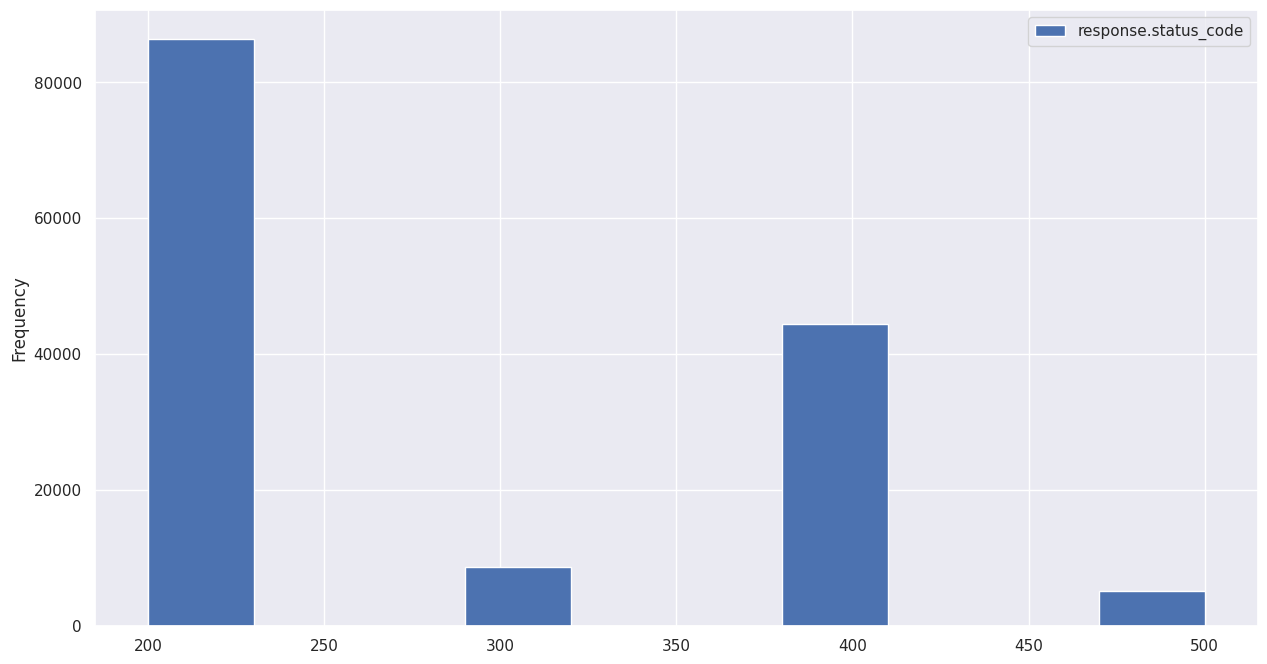

In [ ]:
df.plot.hist(x='response.headers.Content-Type')

<AxesSubplot: xlabel='response.headers.Content-Type', ylabel='count'>

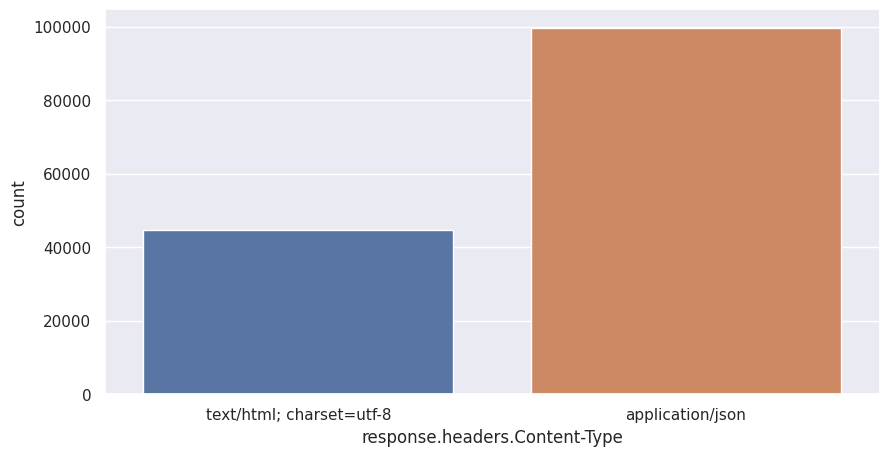

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='response.headers.Content-Type', data=df)


<AxesSubplot: xlabel='response.status', ylabel='Count'>

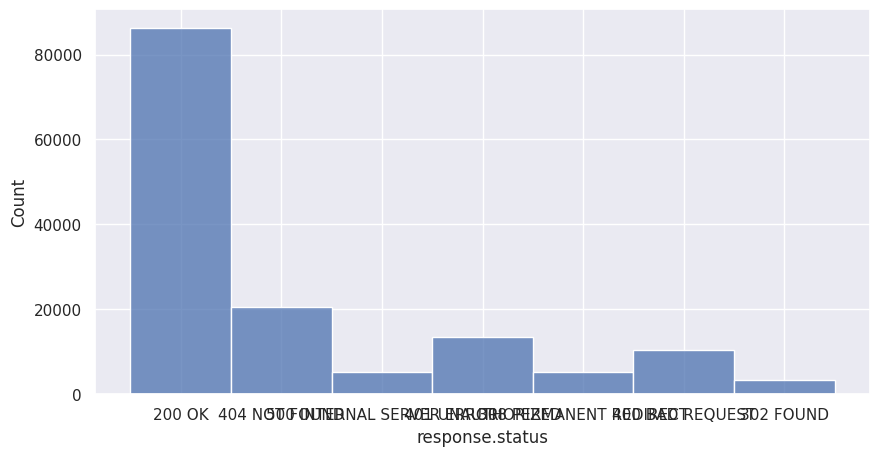

In [ ]:
sns.histplot(x='response.status', data=df)

In [ ]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,Benign,Benign
144497,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=wo-zV78-fKpHPJjNrkXs_EyYZNCJ_VErr0hf4O8l1...,"Thu, 15 Dec 2022 00:47:04 GMT",GET,http://127.0.0.1:5000/greet/Manuel,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=2mYff-_R_5fjojY_G5JZQ1uiY-WO6gdfN09c9nH_R...,"Thu, 15 Dec 2022 00:42:00 GMT",GET,http://127.0.0.1:5000/orders/get/random/6,,200 OK,application/json,20,200,"[{}, {}, {}, {}, {}, {}]",NaN,NaN,NaN,NaN,Benign,

In [ ]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign


In [ ]:
features_list = df.columns.to_list()
print(features_list)

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.headers.Date', 'request.method', 'request.url', 'request.body', 'response.status', 'response.headers.Content-Type', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'attack_type', 'label']


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif


# Select only the feature columns
features_list.remove('attack_type')
features_list.remove('label')

X = df[features_list]

# Preprocess the data to convert non-numeric values to numeric representations
X = X.apply(LabelEncoder().fit_transform)  # Encode categorical features as numeric labels
X = SimpleImputer(strategy='mean').fit_transform(X)  # Impute missing values with the mean

# Extract the target variable
y = df['label']

# Compute mutual information between features and target variable
mi = mutual_info_classif(X, y)

# Print the mutual information values
print(mi)

# Select the top k features based on mutual information
k = 10
top_k_features = np.argsort(mi)[::-1][:k]
print(top_k_features)


[0.         0.01384955 0.03573991 0.         0.         0.01988244
 0.03643151 0.02575946 0.01350001 0.03711753 0.0331312  0.21265943
 0.00065139 0.26450845 0.00526672 0.0851641  0.01604286 0.18303232
 0.08310999 0.09949431 0.04952896 0.05494697 0.0497851  0.02609263]
[13 11 17 19 15 18 21 22 20  9]


### Basic dataset label arrangements

In [ ]:
top_k_feature_names = []
for feature_index in top_k_features:
    feature_name = features_list[feature_index]
    top_k_feature_names.append(feature_name)

print(top_k_feature_names)

['request.url', 'request.headers.Date', 'response.headers.Content-Length', 'response.body', 'response.status', 'response.status_code', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'request.headers.Sec-Fetch-Dest']


In [ ]:
# Create an empty list to store the columns that are not in the top_k_feature_names list
non_top_k_columns = []

# Iterate over the columns in the dataframe
for column in df.columns:
    # If the column is not in the top_k_feature_names list, add it to the non_top_k_columns list
    if column not in top_k_feature_names:
        non_top_k_columns.append(column)

# Print the non_top_k_columns list
print(non_top_k_columns)


['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Set-Cookie', 'request.method', 'request.body', 'response.headers.Content-Type', 'response.headers.Set-Cookie', 'attack_type', 'label']


In [ ]:
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign


In [ ]:
#mark this whole code as a comment: # Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.url', 'response.body', 'response.headers.Content-Length', 'response.status', 
'response.status_code', 'request.headers.Cookie', 'response.headers.Location'
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.method', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'request.headers.Date'
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding',
 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 
     'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 
'request.headers.Set-Cookie', 'request.body', 'response.headers.Content-Type']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Replace np.nan values with an empty string before running HashingVectorizer
    df = df.fillna('')
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df


df = vectorize_df(df)
df.head()

,request.headers.Date,request.method,request.url,response.status,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,-0.948683,0.0,26609,0,1226,0,246,-1.0,2,0,-1.0,RCE,Malware
1,-0.816497,0.0,8568,0,2047,0,246,-1.0,2,0,-1.0,Benign,Benign
2,-0.816497,0.0,72516,0,2024,0,2934,-1.0,2,0,-1.0,Benign,Benign
3,-0.816497,0.0,25950,0,2021,0,0,-1.0,2,0,-1.0,Benign,Benign
4,-0.816497,0.0,51587,5,714,5,5865,-1.0,2,0,-1.0,Benign,Benign


In [ ]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Date             144500 non-null  float64
 1   request.method                   144500 non-null  float64
 2   request.url                      144500 non-null  int64  
 3   response.status                  144500 non-null  int64  
 4   response.headers.Content-Length  144500 non-null  int64  
 5   response.status_code             144500 non-null  int64  
 6   response.body                    144500 non-null  int64  
 7   request.headers.Content-Length   144500 non-null  float64
 8   response.headers.Location        144500 non-null  int64  
 9   request.headers.Cookie           144500 non-null  int64  
 10  response.headers.Set-Cookie      144500 non-null  float64
 11  attack_type                      144500 non-null  object 
 12  la

In [ ]:
top_k_feature_names = [features_list[i] for i in top_k_features]
print(top_k_feature_names)


['request.url', 'request.headers.Date', 'response.headers.Content-Length', 'response.body', 'response.status', 'response.status_code', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'request.headers.Sec-Fetch-Dest']


In [ ]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.
top_k_features= list(top_k_features)
#features_list = df.columns.to_list()
print(top_k_features)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

[13, 11, 17, 19, 15, 18, 21, 22, 20, 9]


request.headers.Date               float64
request.method                     float64
request.url                          int64
response.status                      int64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                        int64
request.headers.Content-Length     float64
response.headers.Location            int64
request.headers.Cookie               int64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: object

In [ ]:
X = df[top_k_feature_names]

# Preprocess the data to convert non-numeric values to numeric representations
X = X.apply(LabelEncoder().fit_transform)  # Encode categorical features as numeric labels
X = SimpleImputer(strategy='mean').fit_transform(X)  # Impute missing values with the mean

KeyError: "['request.headers.Sec-Fetch-Dest'] not in index"

## Train test split

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert the string labels to numeric labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(104996, 10) (104996,)
(22504, 10) (22504,)


## Model choosing and fitting

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert the string labels to numeric labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Train the model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)


RandomForestClassifier()

## Result printout

              precision    recall  f1-score   support

           0    0.98849   0.99481   0.99164     20812
           1    0.93072   0.85757   0.89265      1692

    accuracy                        0.98449     22504
   macro avg    0.95961   0.92619   0.94215     22504
weighted avg    0.98415   0.98449   0.98420     22504



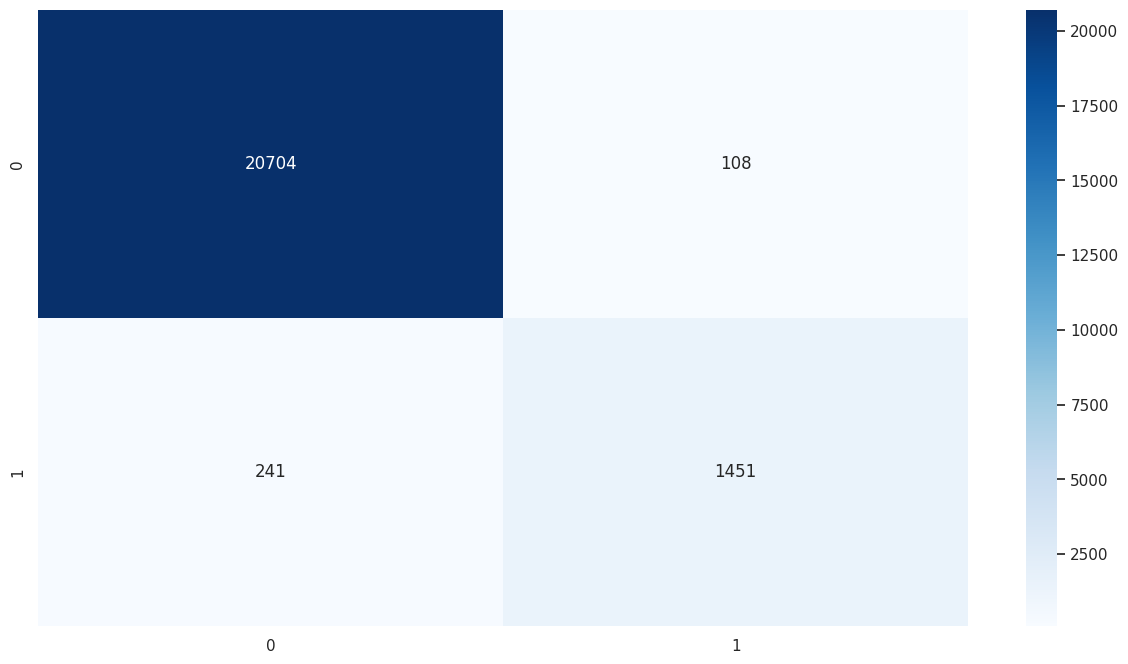

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

In [ ]:
df['label']

0         Benign
1         Benign
2         Benign
3         Benign
4         Benign
           ...  
127495    Benign
127496    Benign
127497    Benign
127498    Benign
127499    Benign
Name: label, Length: 127500, dtype: object

In [ ]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Date', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie']


request.headers.Date               float64
request.method                     float64
request.url                          int64
response.status                      int64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                        int64
response.headers.Location            int64
request.headers.Cookie               int64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: object

In [ ]:
# delete it from complex columns and add it to remove_columns for data set 1 : , 'request.headers.Date'

# Test

In [ ]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
    test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
    test_df = vectorize_df(test_df)

# Predict with your model

    X = test_df[top_k_feature_names].to_numpy()
    predictions = clf.predict(X)

# Save your predictions

In [ ]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')